In [1]:
import jax
import chex
import time

import numpy as np
import jax.numpy as jnp

In [2]:
assert jax.__version__ >= "0.4.30"

In [3]:
jax.devices()

[cuda(id=0),
 cuda(id=1),
 cuda(id=2),
 cuda(id=3),
 cuda(id=4),
 cuda(id=5),
 cuda(id=6),
 cuda(id=7)]

In [4]:
import json
from dataclasses import dataclass
from typing import Any


@dataclass
class HloCommandInfo:
    cmd: str
    metadata: str
    backend_config: str


def parse_hlo_command_line(raw_line: str):
    """Very crude and ugly parsing of an HLO command line!
    """
    metadata: str = None
    backend_cfg = None
    
    # Parse "metadata={...}" block.
    metadata_prefix = ", metadata={"
    lidx = raw_line.find(metadata_prefix)
    if lidx >= 0:
        ridx = raw_line[lidx:].find("}") + lidx
        metadata = raw_line[lidx:ridx+1]
        raw_line = raw_line.replace(metadata, "")
        metadata = metadata[2:]

    # Parse "backend_config={...}" block.
    backend_cfg_prefix = ", backend_config="
    lidx = raw_line.find(backend_cfg_prefix)
    # print(raw_line)
    if lidx >= 0:
        backend_cfg_str = raw_line[lidx + len(backend_cfg_prefix):] 
        # print(raw_line[lidx + len(backend_cfg_prefix):])
        backend_cfg = json.loads(backend_cfg_str)
        raw_line = raw_line[:lidx]
    
    # return (raw_line, metadata, None)
    return HloCommandInfo(raw_line, metadata, backend_cfg)


def parse_hlo_module(module: Any) -> list[HloCommandInfo]:
    """Parse an HLO module, to be human-readable!

    Note: `m.hlo_modules()[0].computations()[0].render_html()`
        is generating HTML output.

    Args:
        module: HLO module or JAX stages compiled instance.
    Returns:
        List of HLO command info.
    """
    module_txt = module.as_text()
    module_lines = module_txt.split("\n")
    cmds = [parse_hlo_command_line(l) for l in module_lines]
    return cmds

def print_hlo_module(module: Any, metadata: bool = False, backend_cfg: bool = False):
    """Human-readable HLO module printing.
    """
    cmds = parse_hlo_module(module)
    for c in cmds:
        print(c.cmd)
        if backend_cfg and c.backend_config:
            print("backend_cfg: ", json.dumps(c.backend_config, indent=4))



In [5]:
M, N, K = 128, 128, 128

In [6]:
a = np.random.randn(M, K).astype(np.float32)
b = np.random.randn(K, N).astype(np.float32)

In [7]:
adtype = jnp.float8_e4m3fn
bdtype = jnp.float8_e4m3fn
bdtype = jnp.float8_e4m3fn
dtype = jnp.float16

a = jax.device_put(a).astype(adtype)
b = jax.device_put(b).astype(bdtype)

2024-07-16 09:10:48.849079: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
# @jax.jit
def matmul_fn(a_fp8, b_fp8, scale):
    # indtype = np.float32
    # d = jax.lax.dot(a_fp8.astype(indtype) * indtype(4), 
    #                 b_fp8.astype(indtype) * indtype(2),
    #                precision="fastest")
    # d = d * jnp.float16(a_fp8[0,0])
    d = jax.lax.dot(a_fp8, b_fp8)
    
    # d = d * jnp.float8_e4m3fn(b_fp8[0,0])
    # d = (d * scale).astype(jnp.float8_e4m3fn)

    
    return d

In [9]:
scale = np.float32(8)

matmul_fn(a, b, scale)

Array([[15, -8, -12, ..., -5.5, -2, -9],
       [-2.5, 4.5, -2.5, ..., -0.5625, -32, -5.5],
       [16, 3.75, 14, ..., -1.625, 8, 28],
       ...,
       [0.4375, -6, -1, ..., -7.5, -9, 2],
       [-1.5, 16, 18, ..., 12, -18, 7.5],
       [-0.75, 2.75, 3.25, ..., 0.0390625, 1.75, -1.375]],      dtype=float8_e4m3fn)

In [10]:
# jax.lax.dot?

In [11]:
lowered = jax.jit(matmul_fn).lower(a, b, scale)
compiled = jax.jit(matmul_fn).lower(a, b, scale).compile()

print(lowered.as_text())

module @jit_matmul_fn attributes {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} {
  func.func public @main(%arg0: tensor<128x128xf8E4M3FN> {mhlo.layout_mode = "default"}, %arg1: tensor<128x128xf8E4M3FN> {mhlo.layout_mode = "default"}) -> (tensor<128x128xf8E4M3FN> {jax.result_info = "", mhlo.layout_mode = "default"}) {
    %0 = stablehlo.dot_general %arg0, %arg1, contracting_dims = [1] x [0], precision = [DEFAULT, DEFAULT] : (tensor<128x128xf8E4M3FN>, tensor<128x128xf8E4M3FN>) -> tensor<128x128xf8E4M3FN>
    return %0 : tensor<128x128xf8E4M3FN>
  }
}



In [12]:
print_hlo_module(compiled, backend_cfg=True)

HloModule jit_matmul_fn, is_scheduled=true, entry_computation_layout={(f8e4m3fn[128,128]{1,0}, f8e4m3fn[128,128]{1,0})->f8e4m3fn[128,128]{1,0}}, allow_spmd_sharding_propagation_to_parameters={true,true}, allow_spmd_sharding_propagation_to_output={true}, frontend_attributes={fingerprint_before_lhs="83c0401cb9ecb5354a8d67d8e531643a"}

%wrapped_transpose_computation (param_0: f8e4m3fn[128,128]) -> f8e4m3fn[128,128] {
  %param_0 = f8e4m3fn[128,128]{1,0} parameter(0)
  ROOT %transpose.1.1 = f8e4m3fn[128,128]{1,0} transpose(f8e4m3fn[128,128]{1,0} %param_0), dimensions={1,0}
}

ENTRY %main.4 (Arg_0.1.0: f8e4m3fn[128,128], Arg_1.2.0: f8e4m3fn[128,128]) -> f8e4m3fn[128,128] {
  %constant_1 = f32[] constant(1)
  %Arg_1.2.0 = f8e4m3fn[128,128]{1,0} parameter(1)
  %Arg_0.1.0 = f8e4m3fn[128,128]{1,0} parameter(0)
  %wrapped_transpose = f8e4m3fn[128,128]{1,0} fusion(f8e4m3fn[128,128]{1,0} %Arg_1.2.0), kind=kInput, calls=%wrapped_transpose_computation
  %cublas-gemm.1.0 = (f8e4m3fn[128,128]{1,0}, s8[

In [13]:
jax.lax.clamp?

Signature: jax.lax.clamp(min: 'ArrayLike', x: 'ArrayLike', max: 'ArrayLike') -> 'Array'
Docstring:
Elementwise clamp.

Returns :math:`\mathrm{clamp}(x) = \begin{cases}
\mathit{min} & \text{if } x < \mathit{min},\\
\mathit{max} & \text{if } x > \mathit{max},\\
x & \text{otherwise}
\end{cases}`.
File:      ~/paulb/env/lib/python3.10/site-packages/jax/_src/lax/lax.py
Type:      function

In [81]:
def quantized_matmul(x_fp8, y_fp8, x_scale, y_scale, z_scale):
    # Dequantize x and y
    f32_x = x_fp8.astype(np.float32) * x_scale
    f32_y = y_fp8.astype(np.float32) * y_scale    
    # Do the matmul
    z = jax.lax.dot(f32_x, f32_y.transpose())
    # New z scale (delayed scaling)
    new_z_scale = jax.lax.reduce_max_p.bind(jax.lax.abs(z), axes=(0, 1))
    # Rescale & clamp.
    z = jax.lax.clamp(np.float32(-448), z * z_scale, np.float32(448))
    # Quantize the matmul output with the old scale
    return jax.lax.convert_element_type(z, jnp.float8_e4m3fn), new_z_scale
    

In [162]:
# x_scale = np.float32(2)
# y_scale = np.float32(4)
# z_scale = np.float32(8)

# qn_lowered = jax.jit(quantized_matmul).lower(a, b, x_scale, y_scale, z_scale)
# qn_compiled = jax.jit(quantized_matmul).lower(a, b, x_scale, y_scale, z_scale).compile()

# print(qn_lowered.as_text())

In [83]:
# print_hlo_module(qn_compiled, backend_cfg=True)

HloModule jit_quantized_matmul, is_scheduled=true, entry_computation_layout={(f8e4m3fn[16384,16384]{1,0}, f8e4m3fn[16384,16384]{1,0}, f32[], f32[], f32[])->(f8e4m3fn[16384,16384]{1,0}, f32[])}, allow_spmd_sharding_propagation_to_parameters={true,true,true,true,true}, allow_spmd_sharding_propagation_to_output={true,true}, frontend_attributes={fingerprint_before_lhs="e083e0b370ca39ac0683bf3914414d9f"}

ENTRY %main.30 (Arg_0.1.0: f8e4m3fn[16384,16384], Arg_1.2.0: f8e4m3fn[16384,16384], Arg_2.3.0: f32[], Arg_3.4.0: f32[], Arg_4.5.0: f32[]) -> (f8e4m3fn[16384,16384], f32[]) {
  %constant_1 = f32[] constant(1)
  %Arg_4.5.0 = f32[] parameter(4)
  %Arg_3.4.0 = f32[] parameter(3)
  %Arg_2.3.0 = f32[] parameter(2)
  %Arg_1.2.0 = f8e4m3fn[16384,16384]{1,0} parameter(1)
  %Arg_0.1.0 = f8e4m3fn[16384,16384]{1,0} parameter(0)
  %cublas-gemm.clone.1.0 = (f8e4m3fn[16384,16384]{1,0}, f32[], s8[33554432]{0}) custom-call(f8e4m3fn[16384,16384]{1,0} %Arg_0.1.0, f8e4m3fn[16384,16384]{1,0} %Arg_1.2.0, f32[] 

In [84]:
# compiled.cost_analysis()

In [85]:
# import jax; jax.print_environment_info()

In [86]:
# jax._src.lib.xla_extension_version

In [216]:
s = 2
M, N, K = 128, 128, 128
M, N, K = 2048, 2048, 2048
# M, N, K = 2048*s, 2048*s, 2048*s

# M = 3456 * s
# N = 4096 * s
# K = 8192 * s

M = 8192 * 1
N = 8192 * 1
K = 8192 * 1

# a = np.random.randn(M, K).astype(np.float32)
# # # b = np.random.randn(K, N).astype(np.float32)
# b = np.random.randn(N, K).astype(np.float32)

a = np.random.randn(M, K).astype(np.float32) / 16
# # b = np.random.randn(K, N).astype(np.float32)
b = np.random.randn(N, K).astype(np.float32) / 16

a = np.zeros((M, K), dtype=np.float32)
b = np.zeros((N, K), dtype=np.float32)

adtype = jnp.float8_e4m3fn
bdtype = jnp.float8_e4m3fn
# adtype = jnp.float16
# bdtype = jnp.float16
# bdtype = jnp.float8_e4m3fn
# dtype = jnp.float16

a = jax.device_put(a).astype(adtype)
b = jax.device_put(b).astype(bdtype)
# out = jax.device_put(b).astype(bdtype)

In [241]:
# @jax.jit
def matmul_fn(a_fp8, b_fp8):
    # out = jax.lax.dot(a_fp8, b_fp8.T, preferred_element_type=jnp.float16)
    out = jax.lax.dot(a_fp8, b_fp8.T)
    return out



def matmul_fn_amax(x_fp8, y_fp8):
    # Dequantize x and y
    f32_x = x_fp8.astype(np.float32) * np.float32(0.5)
    f32_y = y_fp8.astype(np.float32) * np.float32(0.25)    
    # Do the matmul
    z = jax.lax.dot(f32_x, f32_y.transpose())
    # New z scale (delayed scaling)
    new_z_scale = jax.lax.reduce_max_p.bind(jax.lax.abs(z), axes=(0, 1))
    # Rescale & clamp.
    z = jax.lax.clamp(np.float32(-448), z * np.float32(0.125), np.float32(448))
    # Quantize the matmul output with the old scale
    z = jax.lax.convert_element_type(z, jnp.float8_e4m3fn)
    return z, new_z_scale

matmul_compiled = jax.jit(matmul_fn_amax).lower(a, b).compile()

print(jax.jit(matmul_fn).lower(a, b).as_text())
print_hlo_module(matmul_compiled, backend_cfg=True)

module @jit_matmul_fn attributes {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} {
  func.func public @main(%arg0: tensor<8192x8192xf8E4M3FN> {mhlo.layout_mode = "default"}, %arg1: tensor<8192x8192xf8E4M3FN> {mhlo.layout_mode = "default"}) -> (tensor<8192x8192xf8E4M3FN> {jax.result_info = "", mhlo.layout_mode = "default"}) {
    %0 = stablehlo.transpose %arg1, dims = [1, 0] : (tensor<8192x8192xf8E4M3FN>) -> tensor<8192x8192xf8E4M3FN>
    %1 = stablehlo.dot_general %arg0, %0, contracting_dims = [1] x [0], precision = [DEFAULT, DEFAULT] : (tensor<8192x8192xf8E4M3FN>, tensor<8192x8192xf8E4M3FN>) -> tensor<8192x8192xf8E4M3FN>
    return %1 : tensor<8192x8192xf8E4M3FN>
  }
}

HloModule jit_matmul_fn_amax, is_scheduled=true, entry_computation_layout={(f8e4m3fn[8192,8192]{1,0}, f8e4m3fn[8192,8192]{1,0})->(f8e4m3fn[8192,8192]{1,0}, f32[])}, allow_spmd_sharding_propagation_to_parameters={true,true}, allow_spmd_sharding_propagation_to_output={true,true}, frontend_attributes={fingerp

In [218]:
# NUM = 100
# start = time.time()
# outputs = [matmul_compiled(a, b, out).block_until_ready() for idx in range(NUM)]
# # outputs = [v.block_until_ready() for v in outputs]
# end = time.time()

In [219]:
# flops = 2 * M * K * N
# tflops = flops / (end - start) * NUM / 1e12
# print("TFlops:", tflops)

In [220]:
from jax.experimental.mosaic.gpu import profiler

In [225]:
# out, runtime_ms = profiler.measure(matmul_fn, a, b)
out, runtime_ms = profiler.measure(matmul_fn_amax, a, b)
runtime_s = 1e-3 * runtime_ms
# runtime_ms
#
flops = 2 * M * K * N
tflops = flops / runtime_s / 1e12
print("Matmul TFlops:", tflops, a.dtype, b.dtype)

Matmul TFlops: 1734.8146663992247 float8_e4m3fn float8_e4m3fn


In [226]:
tflops / (3958.0 / 2)

0.8766117566443783

In [227]:
print(out)

(Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=float8_e4m3fn), Array(0., dtype=float32))


In [296]:
def matmul_fn_out_fp8(a_fp8, b_fp8):
    out = jax.lax.dot(a_fp8, b_fp8.T)
    return out

def matmul_fn_out_fp8_high(a_fp8, b_fp8):
    out = jax.lax.dot(a_fp8, b_fp8.T, precision=jax.lax.Precision.HIGH)
    return out

def matmul_fn_out_fp16(a_fp8, b_fp8):
    out = jax.lax.dot(a_fp8, b_fp8.T, preferred_element_type=jnp.float16)
    return out

def matmul_fn_with_amax(x_fp8, y_fp8):
    # Dequantize x and y
    f32_x = x_fp8.astype(np.float32) * np.float32(0.5)
    f32_y = y_fp8.astype(np.float32) * np.float32(0.25)    
    # Do the matmul
    z = jax.lax.dot(f32_x, f32_y.transpose())
    # New z scale (delayed scaling)
    new_z_scale = jax.lax.reduce_max_p.bind(jax.lax.abs(z), axes=(0, 1))
    # Rescale & clamp.
    z = jax.lax.clamp(np.float32(-448), z * np.float32(0.125), np.float32(448))
    # Quantize the matmul output with the old scale
    z = jax.lax.convert_element_type(z, jnp.float8_e4m3fn)
    return z, new_z_scale

In [251]:
sizes = np.array([512, 1024, 2048, 4096, 4096*2, 4096*4, 4096*8])
sizes

array([  512,  1024,  2048,  4096,  8192, 16384, 32768])

In [357]:
import jax

def profile_matmul(sizes, matmul_function, zeros: bool=False):
    tflops_list = []
    tflops_list_std = []
    num_tries = 100
    
    for K in sizes:
        M, N = K, K
        print("SIZE:", K)
        key = jax.random.key(K)

        a = jax.random.normal(key, (M, K), dtype=jnp.float16) / 16
        b = jax.random.normal(key, (K, N), dtype=jnp.float16) / 16

        if zeros:
            a = jnp.zeros((M, K), dtype=jnp.float16)
            b = jnp.zeros((K, N), dtype=jnp.float16)
        
        adtype = jnp.float8_e4m3fn
        bdtype = jnp.float8_e4m3fn
        
        a = jax.device_put(a).astype(adtype)
        b = jax.device_put(b).astype(bdtype)

        tflops_measure = []
        for _ in range(num_tries):    
            out, runtime_ms = profiler.measure(matmul_function, a, b)
            runtime_s = 1e-3 * runtime_ms
            tflops =  2 * M * K * N / runtime_s / 1e12
            tflops_measure.append(tflops)
            
        tflops_list.append(np.median(tflops_measure))
        tflops_list_std.append(np.std(tflops_measure))
    return np.array(tflops_list), np.array(tflops_list_std) 

In [376]:
fp8_matmul_out_fp8_tflops, fp8_matmul_out_fp8_tflops_std = profile_matmul(sizes, matmul_fn_out_fp8)

SIZE: 512
SIZE: 1024
SIZE: 2048
SIZE: 4096
SIZE: 8192
SIZE: 16384
SIZE: 32768


In [285]:
fp8_matmul_out_fp16_tflops, fp8_matmul_out_fp16_tflops_std = profile_matmul(sizes, matmul_fn_out_fp16)

SIZE: 512
SIZE: 1024
SIZE: 2048
SIZE: 4096
SIZE: 8192
SIZE: 16384


E0716 13:04:07.082267   18659 buffer_comparator.cc:148] Difference at 251658240: 40.8438, expected 32.0938
E0716 13:04:07.082322   18659 buffer_comparator.cc:148] Difference at 251658241: 40.75, expected 32
E0716 13:04:07.082330   18659 buffer_comparator.cc:148] Difference at 251658242: 40.625, expected 31.875
E0716 13:04:07.082333   18659 buffer_comparator.cc:148] Difference at 251658243: 40.75, expected 31.9219
E0716 13:04:07.082337   18659 buffer_comparator.cc:148] Difference at 251658244: 40.7812, expected 32
E0716 13:04:07.082341   18659 buffer_comparator.cc:148] Difference at 251658245: 40.7812, expected 32.0312
E0716 13:04:07.082345   18659 buffer_comparator.cc:148] Difference at 251658246: 40.25, expected 31.5469
E0716 13:04:07.082364   18659 buffer_comparator.cc:148] Difference at 251658247: 40.875, expected 32.0625
E0716 13:04:07.082369   18659 buffer_comparator.cc:148] Difference at 251658248: 40.75, expected 32.0312
E0716 13:04:07.082373   18659 buffer_comparator.cc:148] Di

SIZE: 32768


E0716 13:04:21.481796   18659 buffer_comparator.cc:148] Difference at 1040187392: 75.6875, expected 50.0312
E0716 13:04:21.481889   18659 buffer_comparator.cc:148] Difference at 1040187393: 75.875, expected 49.9375
E0716 13:04:21.481896   18659 buffer_comparator.cc:148] Difference at 1040187394: 75.8125, expected 50.375
E0716 13:04:21.481900   18659 buffer_comparator.cc:148] Difference at 1040187395: 75.75, expected 50.0938
E0716 13:04:21.481918   18659 buffer_comparator.cc:148] Difference at 1040187396: 75.1875, expected 49.625
E0716 13:04:21.481923   18659 buffer_comparator.cc:148] Difference at 1040187397: 75.3125, expected 49.625
E0716 13:04:21.481927   18659 buffer_comparator.cc:148] Difference at 1040187398: 75.5, expected 49.9688
E0716 13:04:21.481931   18659 buffer_comparator.cc:148] Difference at 1040187399: 75.125, expected 49.625
E0716 13:04:21.481935   18659 buffer_comparator.cc:148] Difference at 1040187400: 75.25, expected 49.5
E0716 13:04:21.481939   18659 buffer_compara

In [291]:
fp8_matmul_out_fp8_high_tflops, fp8_matmul_out_fp8_high_tflops_std = profile_matmul(sizes, matmul_fn_out_fp8_high)

SIZE: 512
SIZE: 1024
SIZE: 2048
SIZE: 4096
SIZE: 8192
SIZE: 16384
SIZE: 32768


In [299]:
fp8_matmul_with_amax_tflops, fp8_matmul_with_amax_tflops_std = profile_matmul(sizes, matmul_fn_with_amax)

SIZE: 512
SIZE: 1024
SIZE: 2048
SIZE: 4096
SIZE: 8192
SIZE: 16384
SIZE: 32768


In [359]:
fp8_matmul_zeros_tflops, fp8_matmul_zeros_std = profile_matmul(sizes, matmul_fn_out_fp8, zeros=True)

SIZE: 512
SIZE: 1024
SIZE: 2048
SIZE: 4096
SIZE: 8192
SIZE: 16384
SIZE: 32768


In [300]:
fp8_matmul_out_fp8_tflops, fp8_matmul_out_fp16_tflops, fp8_matmul_out_fp8_high_tflops, fp8_matmul_with_amax_tflops

(array([   6.75683383,   49.43563485,  334.29072867, 1197.7041882 ,
        1584.01854187, 1630.71317895, 1404.15139473]),
 array([   6.86746581,   49.96937075,  337.33645064, 1251.08374496,
        1585.88289938, 1631.07119913, 1388.14695343]),
 array([   6.51289427,   50.93652571,  323.80633002, 1120.96236185,
        1404.4733467 , 1460.53558441, 1247.39871242]),
 array([   5.37731281,   40.40270319,  281.52643983, 1161.4297762 ,
        1580.19401643, 1631.83614113, 1356.14182692]))

In [289]:
fp8_matmul_out_fp8_tflops / 1979.0, 

(array([0.00341427, 0.02498011, 0.16891901, 0.60520677, 0.80041361,
        0.82400868, 0.70952572]),)

In [363]:
import seaborn as sns
import pandas as pd
import matplotlib
sns.set_theme()

In [380]:
df = pd.DataFrame.from_dict({
    "size": sizes,
    "FP8 x FP8 -> FP16": fp8_matmul_out_fp16_tflops,
    "FP8 x FP8 -> FP8": fp8_matmul_out_fp8_tflops,
    "FP8 x FP8 -> FP8 with amax": fp8_matmul_with_amax_tflops,
    "FP8 x FP8 -> FP8 no fast acc.": fp8_matmul_out_fp8_high_tflops,
    "FP8 x FP8 -> FP8 with zeros": fp8_matmul_zeros_tflops,
    "peak": np.array([1979.0] * len(sizes)),
})
df = df.set_index("size")

In [381]:
df

,FP8 x FP8 -> FP16,FP8 x FP8 -> FP8,FP8 x FP8 -> FP8 with amax,FP8 x FP8 -> FP8 no fast acc.,FP8 x FP8 -> FP8 with zeros,peak
size,,,,,,
512,6.867466,6.751396,5.377313,6.512894,6.859042,1979.0
1024,49.969371,50.025251,40.402703,50.936526,50.382058,1979.0
2048,337.336451,335.754308,281.526440,323.806330,342.830007,1979.0
4096,1251.083745,1202.566831,1161.429776,1120.962362,1294.444751,1979.0
8192,1585.882899,1586.871639,1580.194016,1404.473347,1741.408866,1979.0
16384,1631.071199,1631.250340,1631.836141,1460.535584,1860.507606,1979.0
32768,1388.146953,1385.183192,1356.141827,1247.398712,1639.637944,1979.0


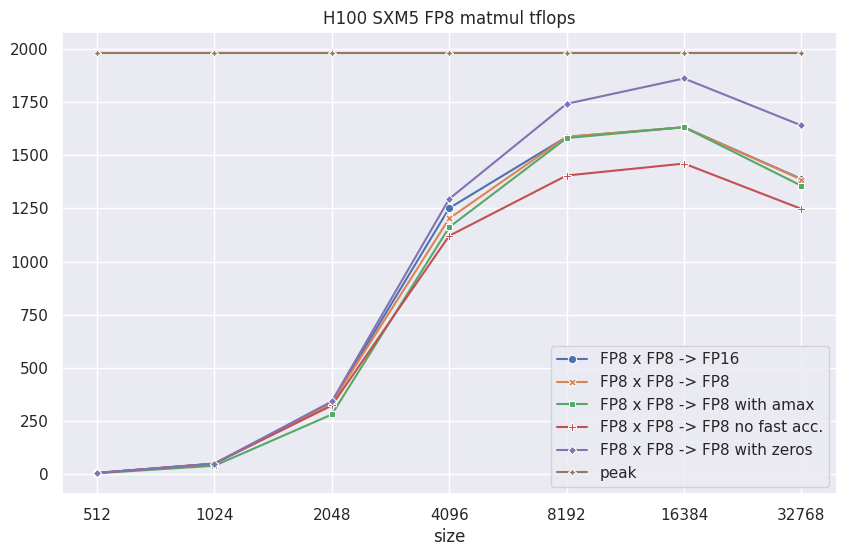

In [382]:
sns.set_theme(rc={'figure.figsize':(10, 6)})

ax = sns.lineplot(df, markers=True, dashes=False)

ax.set_xscale('log')
ax.set_title("H100 SXM5 FP8 matmul tflops")
# ax.set_xticks(sizes)
ax.set_xticks(sizes)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.figure.savefig("matmul_tflops.png", dpi=600, bbox_inches='tight')

In [370]:
fp8_matmul_out_fp8_tflops / 1979.0

array([0.00342254, 0.02525922, 0.17029751, 0.60808953, 0.80102293,
       0.82444889, 0.70729535])

In [372]:
fp8_matmul_zeros_tflops / 1979

array([0.00346591, 0.02545834, 0.17323396, 0.65409032, 0.87994384,
       0.94012512, 0.82851842])

In [371]:
32000**2/1e9

1.024

In [374]:
fp8_matmul_out_fp8_tflops / fp8_matmul_out_fp8_high_tflops

array([1.03996789, 0.98137805, 1.04080353, 1.07355004, 1.12869666,
       1.11711373, 1.12212517])

In [375]:
fp8_matmul_out_fp8_tflops_std

array([ 0.44747028,  4.15991172, 15.89276573, 28.93489917,  2.31982237,
        1.83219627, 25.08537647])